### Libraries

In [1]:
import networkx as nx
from shapely.geometry import Point,LineString,Polygon

import simpy
import xarray as xr

from opentnsim import core as core_module
from opentnsim import graph as graph_module
from opentnsim import lock_new as lock_module
from opentnsim import energy as energy_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module
from opentnsim import zeesluisformulering as ZSF
from netCDF4 import Dataset
import datetime
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.dates as mdates
import folium
from shapely.ops import nearest_points, linemerge, split, snap, transform
import pyproj
import re
path = os.getcwd()

In [2]:
%load_ext autoreload
%autoreload 2

path = os.getcwd()

### Simulation

In [3]:
env = simpy.Environment()
t_start = datetime.datetime(2025, 1, 1, 0, 0, 0)
t_stop = datetime.datetime(2026, 1, 1, 0, 0, 0)

env = simpy.Environment(initial_time=t_start.timestamp())
env.epoch = t_start
env.simulation_start = t_start
env.simulation_stop = t_stop

### Network

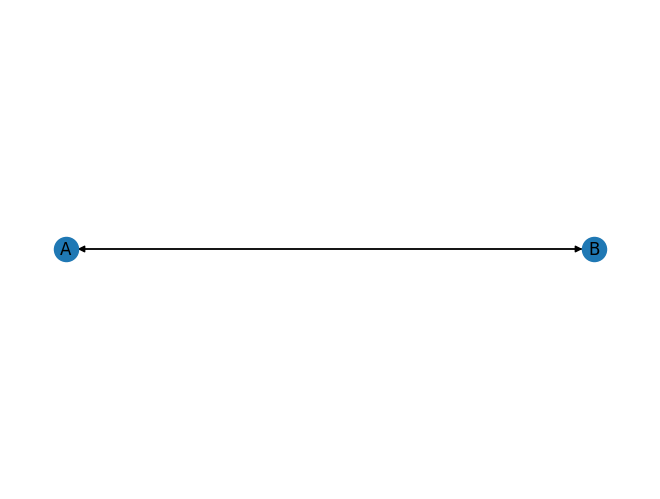

In [4]:
wgs84eqd = pyproj.CRS('4087')
wgs84rad = pyproj.CRS('4326')
wgs84eqd_to_wgs84rad = pyproj.transformer.Transformer.from_crs(wgs84eqd,wgs84rad,always_xy=True).transform
wgs84rad_to_wgs84eqd = pyproj.transformer.Transformer.from_crs(wgs84rad,wgs84eqd,always_xy=True).transform

graph = nx.MultiDiGraph()
graph.add_node('A',geometry=transform(wgs84eqd_to_wgs84rad,Point(-5000,0)))
graph.add_node('B',geometry=transform(wgs84eqd_to_wgs84rad,Point(5000,0)))
graph.add_edge('A','B',geometry=transform(wgs84eqd_to_wgs84rad,LineString([Point(-5000,0),Point(5000,0)])),length=10000)
graph.add_edge('B','A',geometry=transform(wgs84eqd_to_wgs84rad,LineString([Point(5000,0),Point(-5000,0)])),length=10000)
pos = {edge:(point.x,point.y) for edge,point in nx.get_node_attributes(graph, 'geometry').items()}
nx.draw(graph,pos,with_labels=True)
env.FG = graph

### Hydrodynamics

In [5]:
if "hydrodynamic_data_test.nc" not in os.listdir(path+"\\hydrodynamic_data\\"):
    hydrodynamic_data = xr.Dataset()
    times = np.arange(pd.Timestamp('2025-01-01 00:00'),pd.Timestamp('2026-01-01 00:00'),pd.Timedelta(5,'min'))
    nodes = np.array(['A','B'])
    wlevs = np.array([np.array([np.sin((2*np.pi/(12.5*60*60))*x) for x in np.arange(0,365*24*60*60,5*60)]),np.zeros(len(times))])
    salinity = np.array([30*np.ones(len(times)),np.zeros(len(times))])
    wlev_data = xr.DataArray(data=wlevs,coords={'STATION':nodes,'TIME':times})
    salinity_data = xr.DataArray(data=salinity,coords={'STATION':nodes,'TIME':times})
    hydrodynamic_data['Water level'] = wlev_data
    hydrodynamic_data['Salinity'] = salinity_data
    hydrodynamic_data.to_netcdf(path+"\\hydrodynamic_data\\hydrodynamic_data_test.nc")

### Vessel speed

In [6]:
if "speed_test.pkl" not in os.listdir(path+"\\hydrodynamic_data\\"):
    edge_index = [('A','B',0),('B','A',0)]
    data = np.array([4,4])
    vessel_speed_data = pd.DataFrame(data=data,columns=['Speed'],index=edge_index)
    vessel_speed_data.to_pickle(path + '\\speed_test.pkl')
else:
    vessel_speed_data = pickle.read(open(path + '\\speed_test.pkl','rb'))

### Vessel traffic services

In [7]:
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(FG=graph, 
                                                                                hydrodynamic_start_time = pd.Timestamp('2025-01-01 00:00'),
                                                                                hydrodynamic_information_path = path+"\\hydrodynamic_data\\hydrodynamic_data_test.nc", 
                                                                                vessel_speed_data_path = path + '\\speed_test.pkl')

### Lock object

In [8]:
lock = lock_module.IsLockComplex(env=env,
                                 name='Lock',
                                 start_node='A',
                                 node_open='A',
                                 end_node='B',
                                 approach_node_A = 'A',
                                 approach_node_B = 'B',
                                 distance_lock_doors_A_to_waiting_area_A = 4800,
                                 distance_lock_doors_B_to_waiting_area_B = 4800,
                                 distance_from_start_node_to_lock_doors_A = 4800,
                                 distance_from_end_node_to_lock_doors_B = 4800,
                                 lock_length = 400,
                                 lock_width = 50,
                                 lock_depth = 15,
                                 levelling_time = 300,
                                 disch_coeff = 0.65,
                                 gate_opening_time = 120,
                                 opening_area = 80,
                                 sailing_distance_to_crossing_point = 1800,
                                 doors_opening_time= 300,
                                 doors_closing_time= 300,
                                 speed_reduction_factor_lock_chamber=0.5,
                                 sailing_in_time_gap = 300,
                                 sailing_in_speed = 1.5,
                                 sailing_out_time_gap = 120,
                                 time_step = 30,
                                 sailing_time_before_opening_lock_doors = 600,
                                 sailing_time_before_closing_lock_doors = 120,
                                 detector_nodes = ['A','B'],
                                 predictive=False)

### Vessels

In [9]:
Vessel = type('Vessel',(energy_module.ConsumesEnergy,lock_module.PassesLockComplex,vessel_module.IsVessel,),{}) 

In [10]:
vessel_1 = Vessel(**{"env": env,
                     "name": 'Vessel 1',
                     "origin": 'A',
                     "destination": 'B',
                     "type": 'tanker',
                     "bound": 'outbound',
                     "L": 100,
                     "B": 20,
                     "T": 10,
                     "v": 4,
                     "P_installed": 50000*1000,
                     "C_year": 2010,
                     "L_w":3,
                     "arrival_time": pd.Timestamp('2025-01-01 00:00:00')})
vessel_1.process = env.process(vessel_1.move())

vessel_2 = Vessel(**{"env": env,
                     "name": 'Vessel 2',
                     "origin": 'B',
                     "destination": 'A',
                     "type": 'tanker',
                     "bound": 'outbound',
                     "L": 100,
                     "B": 20,
                     "T": 10,
                     "v": 4,
                     "P_installed": 50000*1000,
                     "C_year": 2010,
                     "L_w":3,
                     "C_year": 2010,
                     "arrival_time": pd.Timestamp('2025-01-01 00:05:00')})
vessel_2.process = env.process(vessel_2.move())

# vessel_3 = Vessel(**{"env": env,
#                      "name": 'Vessel 3',
#                      "origin": 'A',
#                      "destination": 'B',
#                      "type": 'tanker',
#                      "bound": 'inbound',
#                      "L": 100,
#                      "B": 20,
#                      "T": 10,
#                      "v": 4,
#                      "P_installed": 50000*1000,
#                      "C_year": 2010,
#                      "L_w":3,
#                      "arrival_time": pd.Timestamp('2025-01-01 00:10:00')})
# vessel_3.process = env.process(vessel_3.move())

# vessel_4 = Vessel(**{"env": env,
#                      "name": 'Vessel 4',
#                      "origin": 'A',
#                      "destination": 'B',
#                      "type": 'tanker',
#                      "bound": 'inbound',
#                      "L": 100,
#                      "B": 20,
#                      "T": 10,
#                      "v": 4,
#                      "P_installed": 50000*1000,
#                      "C_year": 2010,
#                      "L_w":3,
#                      "arrival_time": pd.Timestamp('2025-01-01 00:15:00')})
# vessel_4.process = env.process(vessel_4.move())

# vessel_5 = Vessel(**{"env": env,
#                      "name": 'Vessel 5',
#                      "origin": 'A',
#                      "destination": 'B',
#                      "type": 'tanker',
#                      "bound": 'inbound',
#                      "L": 100,
#                      "B": 20,
#                      "T": 10,
#                      "v": 4,
#                      "P_installed": 50000*1000,
#                      "C_year": 2010,
#                      "L_w":3,
#                      "arrival_time": pd.Timestamp('2025-01-01 00:12:00')})
# vessel_5.process = env.process(vessel_5.move())

vessels = []
vessels.append(vessel_1)
vessels.append(vessel_2)
# vessels.append(vessel_3)
# vessels.append(vessel_4)
# vessels.append(vessel_5)

### Run model

In [11]:
env.run()

0 days 00:00:00 2025-01-01 00:12:30 2025-01-01 00:12:30 2025-01-01 00:00:00 0 days 00:12:30


,bound,L,B,T,operation_index,time_of_registration,time_of_acceptance,time_arrival_at_waiting_area,time_arrival_at_lineup_area,time_lock_passing_start,time_lock_entry_start,time_lock_entry_stop,time_lock_departure_start,time_lock_departure_stop,time_lock_passing_stop,delay,time_potential_lock_door_opening_stop,time_potential_lock_door_closure_start
id,,,,,,,,,,,,,,,,,,
c1e2e12d-67d3-45c7-8cc7-d7ffd85233fc,0,100,20,10,0,2025-01-01 00:00:00,2025-01-01 00:00:00,2025-01-01 00:00:00,NaN,2025-01-01 00:12:30,2025-01-01 00:24:58.276065249,2025-01-01 00:29:16.446356473,2025-01-01 00:44:16.446356473,2025-01-01 00:45:14.889549156,2025-01-01 00:53:17.839581245,0 days,2025-01-01 00:14:27.061980557,2025-01-01 00:27:23.962524250


0 days 00:35:47.839581245 2025-01-01 00:53:17.839581245 2025-01-01 00:17:30 2025-01-01 00:05:00 0 days 00:12:30


,bound,L,B,T,operation_index,time_of_registration,time_of_acceptance,time_arrival_at_waiting_area,time_arrival_at_lineup_area,time_lock_passing_start,time_lock_entry_start,time_lock_entry_stop,time_lock_departure_start,time_lock_departure_stop,time_lock_passing_stop,delay,time_potential_lock_door_opening_stop,time_potential_lock_door_closure_start
id,,,,,,,,,,,,,,,,,,
c1e2e12d-67d3-45c7-8cc7-d7ffd85233fc,0,100,20,10,0,2025-01-01 00:00:00,2025-01-01 00:00:00,2025-01-01 00:00:00,NaN,2025-01-01 00:12:30,2025-01-01 00:24:58.276065249,2025-01-01 00:29:16.446356473,2025-01-01 00:44:16.446356473,2025-01-01 00:45:14.889549156,2025-01-01 00:53:17.839581245,0 days,2025-01-01 00:14:27.061980557,2025-01-01 00:27:23.962524250
70af7a92-6298-4591-bfdb-8a725da3c68d,1,100,20,10,1,2025-01-01 00:05:00,2025-01-01 00:05:00,2025-01-01 00:05:00,NaN,2025-01-01 00:53:17.839581245,2025-01-01 01:05:46.115646494,2025-01-01 01:10:04.285937718,2025-01-01 01:25:04.285937718,2025-01-01 01:26:02.729130401,2025-01-01 01:34:05.679162490,0 days,2025-01-01 00:55:14.901561802,2025-01-01 01:08:11.802105495


0.0 2025-01-01 00:53:17.839581245 2025-01-01 00:53:17.839581


In [12]:
pd.Timestamp('2025-01-01 00:35:40')+pd.Timedelta(seconds=500)

Timestamp('2025-01-01 00:44:00')

In [13]:
all_times = []
all_distances = []
lock_edge_geometry = transform(wgs84rad_to_wgs84eqd,graph.edges['A','B',0]['geometry'])
for vessel in vessels:
    times = []
    distances = []
    vessel_df = pd.DataFrame(vessel.logbook)
    vessel_df['Geometry'] = vessel_df['Geometry'].apply(lambda x: transform(wgs84rad_to_wgs84eqd,x))  
    for index,message_info in vessel_df.iterrows():
        time = message_info.Timestamp
        distance = lock_edge_geometry.line_locate_point(message_info.Geometry)-lock_edge_geometry.length/2
        origin = message_info.Value['origin']
        destination = message_info.Value['destination']
        edge_length = env.FG.edges[origin,destination,0]['length']
        direction = 0
        if origin != lock.start_node:
            direction = 1
        if message_info.Message == 'Sailing to first lock doors stop':   
            v0 = vessel_speed_data[vessel_speed_data.index == (origin,destination,0)].iloc[0].Speed
            v_target = lock.sailing_in_speed
            output = vessel.distance_to_desired_speed(v_target=v_target,P_used=0,h0=17,v0=v0)
            if not direction:
                distances_from_end = -1*(np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
            else:
                distances_from_end = (np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
            times.extend(times_slowing_down) 
            distances.extend(distances_slowing_down)
            times.append(time)
            distances.append(distance)
        elif message_info.Message == 'Sailing to position in lock stop':
            v0 = lock.sailing_in_speed
            v_target = 0.1
            output = vessel.distance_to_desired_speed(v_target=v_target,P_used=0.005,h0=lock.lock_depth,v0=v0)
            if not direction:
                distances_from_end = -1*(np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
            else:
                distances_from_end = (np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
            times.extend(times_slowing_down) 
            distances.extend(distances_slowing_down)
            times.append(time)
            distances.append(distance)
        elif message_info.Message == 'Sailing to second lock doors start':
            times.append(time)
            distances.append(distance)
            v0 = 0.1
            v_target = lock.sailing_out_speed
            output = vessel.distance_to_desired_speed(v_target=v_target,P_used=0.005,h0=lock.lock_depth,v0=v0)
            if not direction:
                distances_from_start = np.append(np.array(0),np.array(output['distance']))
                distances_accelerating = distance+distances_from_start
                times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
            else:
                distances_from_start = -1*np.append(np.array(0),np.array(output['distance']))
                distances_accelerating = distance+distances_from_start
                times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
            times.extend(times_accelerating) 
            distances.extend(distances_accelerating)
        elif message_info.Message == 'Sailing to lock complex exit start':
            times.append(time)
            distances.append(distance)
            v0 = lock.sailing_out_speed
            v_target = vessel_speed_data[vessel_speed_data.index == (origin,destination,0)].iloc[0].Speed
            output = vessel.distance_to_desired_speed(v_target=v_target,P_used=0.02,h0=17,v0=v0)
            if not direction:
                distances_from_start = np.append(np.array(0),np.array(output['distance']))
                distances_accelerating = distance+distances_from_start
                times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
            else:
                distances_from_start = -1*np.append(np.array(0),np.array(output['distance']))
                distances_accelerating = distance+distances_from_start
                times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
            times.extend(times_accelerating) 
            distances.extend(distances_accelerating)
        else:
            times.append(time)
            distances.append(distance)
            
    all_times.append(times)
    all_distances.append(distances)

In [14]:
output = vessel.distance_to_desired_speed(v_target=v_target,P_used=0.02,h0=17,v0=v0)

In [15]:
vessel_df

,Message,Timestamp,Value,Geometry
0,Sailing from node B to node A start,2025-01-01 00:05:00.000000,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (5000 0)
1,Waiting start,2025-01-01 00:05:00.000000,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (5000 0)
2,Waiting stop,2025-01-01 00:40:47.839581,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (5000 0)
3,Sailing to first lock doors start,2025-01-01 00:40:47.839581,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (5000 0)
4,Sailing to first lock doors stop,2025-01-01 01:05:46.115646,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (199.99999999999963 0)
5,Sailing to position in lock start,2025-01-01 01:05:46.115646,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (199.99999999999963 0)
6,Sailing to position in lock stop,2025-01-01 01:10:04.285938,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (-150.00000000000068 0)
7,Levelling start,2025-01-01 01:15:04.285938,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (-150.00000000000068 0)
8,Levelling stop,2025-01-01 01:20:04.285938,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (-150.00000000000068 0)
9,Sailing to second lock doors start,2025-01-01 01:25:04.285938,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (-150.00000000000068 0)


In [16]:
lock_df = pd.DataFrame(lock.logbook)

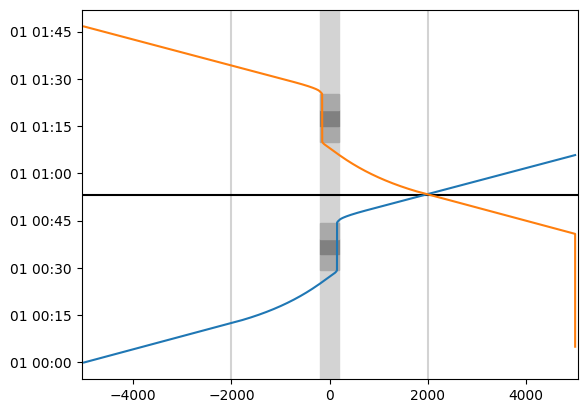

In [17]:
fig,ax = plt.subplots()

for distances,times in zip(all_distances,all_times):
    ax.plot(distances,times)

ylimmin,ylimmax = ax.get_ylim()

#Plot lock chamber
x_lock_doorsA = lock_edge_geometry.line_locate_point(transform(wgs84rad_to_wgs84eqd,lock.location_lock_doors_A))-lock_edge_geometry.length/2
x_lock_doorsB = lock_edge_geometry.line_locate_point(transform(wgs84rad_to_wgs84eqd,lock.location_lock_doors_B))-lock_edge_geometry.length/2
lock_extend_x = [x_lock_doorsA,x_lock_doorsA,x_lock_doorsB,x_lock_doorsB]
ax.fill(lock_extend_x,[ylimmin,ylimmax,ylimmax,ylimmin],color='lightgrey',zorder=0)

#Plot lock phases
for index, message_info in lock_df.iterrows():
    if message_info.Message == 'Lock doors opening stop' and index != 0:
        time_start = lock_df.loc[index-1,'Timestamp'] 
        time_stop = message_info.Timestamp
        ax.fill(lock_extend_x,[time_start,time_stop,time_stop,time_start],color='darkgrey',zorder=0)
    if message_info.Message == 'Lock doors closing stop' and index != 0:
        time_start = lock_df.loc[index-1,'Timestamp'] 
        time_stop = message_info.Timestamp
        ax.fill(lock_extend_x,[time_start,time_stop,time_stop,time_start],color='darkgrey',zorder=0)
    if message_info.Message == 'Lock chamber converting stop' and index != 0:
        time_start = lock_df.loc[index-1,'Timestamp'] 
        time_stop = message_info.Timestamp
        ax.fill(lock_extend_x,[time_start,time_stop,time_stop,time_start],color='grey',zorder=0)

ax.axvline(-2000,color='lightgrey',zorder=0)
ax.axvline(2000,color='lightgrey',zorder=0)
ax.axhline(pd.Timestamp('2025-01-01 00:53'),color='k',zorder=0)
ax.set_xlim(-5050,5050);
ax.set_ylim(ylimmin,ylimmax);

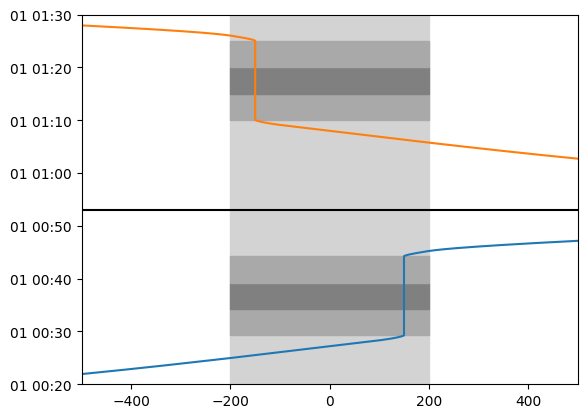

In [18]:
ax.set_xlim(-500,500)
ax.set_ylim(pd.Timestamp('2025-01-01 00:20'),pd.Timestamp('2025-01-01 01:30'))
fig

In [19]:
lock.operation_planning

,bound,vessels,capacity_L,capacity_B,time_potential_lock_door_opening_stop,time_operation_start,time_entry_start,time_entry_stop,time_door_closing_start,time_door_closing_stop,...,time_door_opening_stop,time_departure_start,time_departure_stop,time_operation_stop,time_potential_lock_door_closure_start,wlev_A,wlev_B,maximum_individual_delay,total_delay,status
lock_operation,,,,,,,,,,,,,,,,,,,,,
0,0,[<__main__.Vessel object at 0x0000028C12D37A60>],300,30,2025-01-01 00:14:27.061980557,2025-01-01 00:12:30,2025-01-01 00:24:58.276065249,2025-01-01 00:29:16.446356473,2025-01-01 00:29:16.446356473,2025-01-01 00:34:16.446356473,...,2025-01-01 00:44:16.446356473,2025-01-01 00:44:16.446356473,2025-01-01 00:45:14.889549156,2025-01-01 00:53:17.839581245,2025-01-01 00:47:40.576008157,0.289032,0.0,0 days 00:00:00,0 days 00:00:00,ready
1,1,[<__main__.Vessel object at 0x0000028C12D367A0>],300,30,2025-01-01 00:55:14.901561802,2025-01-01 00:53:17.839581245,2025-01-01 01:05:46.115646494,2025-01-01 01:10:04.285937718,2025-01-01 01:10:04.285937718,2025-01-01 01:15:04.285937718,...,2025-01-01 01:25:04.285937718,2025-01-01 01:25:04.285937718,2025-01-01 01:26:02.729130401,2025-01-01 01:34:05.679162490,2025-01-01 01:28:28.415589402,0.621148,0.0,0 days 00:00:00,0 days 00:00:00,ready


In [20]:
#List of tests to be required for one ship inbound, one ship outbound scenario (from simple to challenging):
#- crossing at 1800 m
#- crossing at 300 m